This notebook does the following for the RESNET50V2 backbone:



*   Train model without any pre-loaded weights
*   Train model using transfer learning with and without fine tuning 







IMPORT LIBRARIES AND MOUNT GOOGLE DRIVE
---

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!pip install bayesian-optimization

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os 
import numpy as np 
import keras 
# import re 
import cv2 
import matplotlib.pyplot as plt
import pandas as pd
import sklearn 
from sklearn.model_selection import cross_val_score

from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf 
from keras.applications.resnet import ResNet50, preprocess_input
from keras.models import Model
from keras import layers
# from bayes_opt import BayesianOptimization as bo


LOAD DATA
---


In [ ]:
os.chdir('drive/MyDrive/COMP90055/code/all_data')


FileNotFoundError: ignored

In [ ]:
bad_coastal = [4,5,31,39,68,69,74,75,76,89,90,102,121,206,216,217,220,221,248,249,309,310,313,315,316,336,337,361,431,443,488]
weird = [33,35,52,55,276,333,334,335,444]

exclude = [str(num) + ".png" for num in bad_coastal + weird]

In [ ]:

## Load masks
mask_directory = '224_masks_filtered'
image_directory = '224_images_filtered'

# mask_filenames = [filename for filename in os.listdir(mask_directory) if filename.endswith(('.png', '.jpeg', '.jpg'))] - exclude
mask_filenames = [filename for filename in os.listdir(mask_directory) if filename.endswith(('.png', '.jpeg', '.jpg')) and filename not in exclude]



filenames = mask_filenames


masks = []

for filename in filenames:

    mask = cv2.imread(os.path.join(mask_directory, filename), cv2.IMREAD_GRAYSCALE)
    # plt.imshow(mask)
    mask[mask == 2] = 0 ## This removes the cloud mask 

    masks.append(mask)

masks_array = np.array(masks)


images = []


for filename in filenames:
  
    image = cv2.imread(os.path.join(image_directory, filename))
    images.append(image)


images_array = np.array(images)
images_array = preprocess_input(images_array)
images_array, masks_array = sklearn.utils.shuffle(images_array, masks_array, random_state = 90055)


print(images_array.shape)
print(masks_array.shape)

(484, 224, 224, 3)
(484, 224, 224)


In [ ]:
train_index = int(images_array.shape[0] * 0.7)
val_index = int(images_array.shape[0] * 0.2)

x_train = images_array[:train_index]
x_val = images_array[train_index:train_index + val_index]
x_test = images_array[train_index + val_index:]

y_train = masks_array[:train_index]
y_val = masks_array[train_index:train_index + val_index]
y_test = masks_array[train_index + val_index:]

final_x_train = images_array[:train_index+val_index]
final_y_train = masks_array[:train_index+val_index]

LOSS FUNCTIONS
---

In [ ]:
from keras.losses import BinaryFocalCrossentropy as BFCE

def dice_loss(y_true, y_pred):
  y_true = tf.cast(y_true, tf.float32)
  y_pred = tf.math.sigmoid(y_pred)
  numerator = 2 * tf.reduce_sum(y_true * y_pred)
  denominator = tf.reduce_sum(y_true + y_pred)

  return 1 - numerator / denominator


def dice_focal_loss(y_true, y_pred):
  bin_foc = BFCE()
  return dice_loss(y_true, y_pred) + bin_foc(y_true, y_pred)

MODELS with DEEPLABV3+
---
---


Some functions for constructing the model

Taken from https://keras.io/examples/vision/deeplabv3_plus/ and modified to include dropouts and accomodate transfer and non trasnfer learing


In [ ]:
def convolution_block(
    block_input,
    num_filters=256,
    kernel_size=3,
    dilation_rate=1,
    padding="same",
    use_bias=False,
    dropout=0
):
    x = layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding="same",
        use_bias=use_bias,
        kernel_initializer=keras.initializers.HeNormal(),
    )(block_input)
    x = layers.BatchNormalization()(x)
    x = tf.nn.relu(x)
    x = layers.Dropout(dropout)(x)

    return x


def DilatedSpatialPyramidPooling(dspp_input, dropout_rate = 0):
    dims = dspp_input.shape
    x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True , dropout = dropout_rate)
    out_pool = layers.UpSampling2D(
        size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]), interpolation="bilinear",
    )(x)

    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1, dropout = dropout_rate)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6, dropout = dropout_rate)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12, dropout = dropout_rate)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18, dropout = dropout_rate)

    x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1, dropout = dropout_rate)
    return output

In [ ]:
def DeeplabV3Plus(image_size, num_classes, weights=None, frozen_base=False, dropout_rate = 0 ):
    
    model_input = keras.Input(shape=(image_size, image_size, 3))
    # flipped_input = layers.RandomFlip(mode="horizontal")(model_input)
    # flipped_input = layers.RandomFlip(mode="vertical")(flipped_input)s


    resnet50 = keras.applications.ResNet50(
        weights=weights, include_top=False, input_tensor=model_input  # Change here for transfer learning
    )

    
    if frozen_base:
        resnet50.trainable = False

    x = resnet50.get_layer("conv4_block6_1_relu").output ## Resnet50V2
    # x = resnet50.get_layer("conv4_block6_2_relu").output ## Resnet50
    x = DilatedSpatialPyramidPooling(x, dropout_rate = dropout_rate)

    input_a = layers.UpSampling2D(
        size=(image_size // 4 // x.shape[1], image_size // 4 // x.shape[2]),
        interpolation="bilinear",
    )(x)

    input_b = resnet50.get_layer("conv2_block3_1_relu").output ##Resnet50v2
    # input_b = resnet50.get_layer("conv2_block3_2_relu").output ## Resnet50
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)

    x = layers.Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x, dropout = dropout_rate)
    x = convolution_block(x, dropout = dropout_rate)
    x = layers.UpSampling2D(
        size=(image_size // x.shape[1], image_size // x.shape[2]),
        interpolation="bilinear",
    )(x)
    model_output = layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same", activation='sigmoid')(x)


    return keras.Model(inputs=model_input, outputs=model_output)


Checking our loss functions
---

In [ ]:
tf.keras.backend.clear_session()
model_noweights_dice = DeeplabV3Plus(image_size=224, num_classes=1)
# model_noweights.summary()

model_noweights_dice.compile( optimizer =keras.optimizers.Adam()
              ,loss= dice_loss
              ,metrics=[ 'accuracy' , tf.keras.metrics.Recall() , tf.keras.metrics.Precision()]
              )


history_dice = model_noweights_dice.fit(x = x_train, y = y_train, validation_data = (x_val,y_val), epochs = 50) 



In [ ]:
tf.keras.backend.clear_session()
model_noweights_combo = DeeplabV3Plus(image_size=224, num_classes=1)
# model_noweights.summary()

model_noweights_combo.compile( optimizer =keras.optimizers.Adam()
              ,loss= dice_focal_loss
              ,metrics=[ 'accuracy' , tf.keras.metrics.Recall() , tf.keras.metrics.Precision()]
              )


history_combo = model_noweights_combo.fit(x = x_train, y = y_train, validation_data = (x_val,y_val), epochs = 50) 


In [ ]:
tf.keras.backend.clear_session()
model_noweights_bfce = DeeplabV3Plus(image_size=224, num_classes=1)
# model_noweights.summary()

model_noweights_bfce.compile( optimizer =keras.optimizers.Adam()
              ,loss= BFCE()
              ,metrics=[ 'accuracy' , tf.keras.metrics.Recall() , tf.keras.metrics.Precision()]
              )


history_bfce = model_noweights_bfce.fit(x = x_train, y = y_train, validation_data = (x_val,y_val), epochs = 50) 


NO PRE LOADED WEIGHTS
---

Hyper Parameter Tuning

In [ ]:
from bayes_opt import BayesianOptimization

# Import the required loss functions

# Define the objective function
def objective(learning_rate, dropout_rate):
    # Build the model with the current hyperparameters
    tf.keras.backend.clear_session()

    model = DeeplabV3Plus(224, 1, dropout_rate=dropout_rate)

   

    datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True)

    model.compile(optimizer=keras.optimizers.Adam(learning_rate = learning_rate), loss=dice_loss,
                  metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

    history = model.fit(datagen.flow(x_train, y_train, batch_size=16),
                        validation_data=(x_val, y_val), epochs=100, verbose=0)

    p = history.history['val_precision'][-1]
    r = history.history['val_recall'][-1]

    f1 = 2*(p*r)/(p+r)

    # Return the validation accuracy as the objective value to maximize
    return f1

# Define the parameter space
pbounds = {'learning_rate': (1e-5, 1e-2),
           'dropout_rate': (0, 0.5)
           }

# Create the optimizer
optimizer = BayesianOptimization(f=objective, pbounds=pbounds)

# Perform the optimization
optimizer.maximize(init_points=5, n_iter=10)

# Get the best set of hyperparameters
best_params = optimizer.max['params']
print(best_params)


# best_learning_rate = best_params['learning_rate']
# best_dropout_rate = best_params['dropout_rate']
# best_loss_function = best_params['loss_function']



|   iter    |  target   | dropou... | learni... |
-------------------------------------------------
| 1         | 0.02234   | 0.03463   | 0.007593  |
| 2         | 0.02109   | 0.0827    | 0.007708  |
| 3         | 0.02119   | 0.0566    | 0.002346  |
| 4         | 0.0231    | 0.08398   | 0.0002347 |
| 5         | 0.02279   | 0.3282    | 0.009918  |
| 6         | 0.05424   | 0.1386    | 0.00928   |
| 7         | 0.03236   | 0.1687    | 1e-05     |
| 8         | 0.03704   | 0.1264    | 1e-05     |
| 9         | 0.02098   | 0.1487    | 0.009909  |
| 10        | 0.04138   | 0.06511   | 0.001499  |
| 11        | 0.03253   | 0.1388    | 0.007999  |
| 12        | 0.02292   | 0.1381    | 0.009364  |
| 13        | 0.02482   | 0.1389    | 0.007839  |
| 14        | 0.0369    | 0.2155    | 0.004313  |
| 15        | 0.04376   | 0.1385    | 0.00914   |
{'dropout_rate': 0.13857637974829567, 'learning_rate': 0.009279677186633268}


In [ ]:
tf.keras.backend.clear_session()

datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True)
tuned_model = DeeplabV3Plus(224, 1, dropout_rate=0.13857637974829567)   
tuned_model.compile( optimizer =keras.optimizers.Adam(0.009279677186633268)
              ,loss= dice_loss
              ,metrics=[ 'accuracy' , tf.keras.metrics.Recall() , tf.keras.metrics.Precision()]
              )

tuned_history = tuned_model.fit(datagen.flow(x_train, y_train, batch_size=16),
                      validation_data=(x_val, y_val), epochs=500)

tuned_model.save("resnetDLV3_NW_tuned_500e_bs16.h5")

np.save('history_resnetDLV3_NW_tuned_500e_bs16.npy',tuned_history.history)


Epoch 1/500
22/22 [==============================] - 13s 337ms/step - loss: 0.9790 - accuracy: 0.7085 - recall: 0.3362 - precision: 0.0123 - val_loss: 0.9790 - val_accuracy: 0.4986 - val_recall: 0.5135 - val_precision: 0.0109
Epoch 2/500
22/22 [==============================] - 6s 286ms/step - loss: 0.9785 - accuracy: 0.6312 - recall: 0.4740 - precision: 0.0135 - val_loss: 0.9790 - val_accuracy: 0.0560 - val_recall: 0.9664 - val_precision: 0.0108
Epoch 3/500
22/22 [==============================] - 6s 286ms/step - loss: 0.9781 - accuracy: 0.7101 - recall: 0.4434 - precision: 0.0161 - val_loss: 0.9790 - val_accuracy: 0.0106 - val_recall: 1.0000 - val_precision: 0.0106
Epoch 4/500
22/22 [==============================] - 6s 288ms/step - loss: 0.9781 - accuracy: 0.7059 - recall: 0.4489 - precision: 0.0161 - val_loss: 0.9790 - val_accuracy: 0.0127 - val_recall: 0.9992 - val_precision: 0.0107
Epoch 5/500
22/22 [==============================] - 6s 287ms/step - loss: 0.9778 - accuracy: 0.678

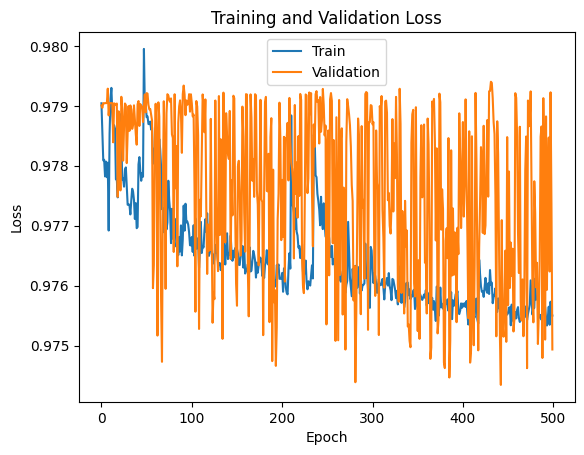

In [ ]:
## Assess at which point the model becomes overfit 

resDL_NW_hist = np.load("history_resnetDLV3_NW_tuned_500e_bs16.npy", allow_pickle = True).item()

resDL_NW_hist['loss']


plt.plot(resDL_NW_hist['loss'], label='Train')
plt.plot(resDL_NW_hist['val_loss'], label='Validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

Relatively unclear based on training. Default to 100 epochs

In [ ]:
tf.keras.backend.clear_session()

datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True)
tuned_model = DeeplabV3Plus(224, 1, dropout_rate=0.13857637974829567)   
tuned_model.compile( optimizer =keras.optimizers.Adam(0.009279677186633268)
              ,loss= dice_loss
              ,metrics=[ 'accuracy' , tf.keras.metrics.Recall() , tf.keras.metrics.Precision()]
              )

tuned_history = tuned_model.fit(datagen.flow(final_x_train, final_y_train, batch_size=16), epochs=100)


Epoch 1/100
28/28 [==============================] - 9s 95ms/step - loss: 0.9791 - accuracy: 0.4582 - recall: 0.5832 - precision: 0.0113
Epoch 2/100
28/28 [==============================] - 3s 94ms/step - loss: 0.9788 - accuracy: 0.4323 - recall: 0.6468 - precision: 0.0119
Epoch 3/100
28/28 [==============================] - 3s 94ms/step - loss: 0.9782 - accuracy: 0.6115 - recall: 0.5366 - precision: 0.0145
Epoch 4/100
28/28 [==============================] - 3s 96ms/step - loss: 0.9782 - accuracy: 0.6505 - recall: 0.4909 - precision: 0.0148
Epoch 5/100
28/28 [==============================] - 3s 94ms/step - loss: 0.9783 - accuracy: 0.6876 - recall: 0.4418 - precision: 0.0150
Epoch 6/100
28/28 [==============================] - 3s 94ms/step - loss: 0.9781 - accuracy: 0.6632 - recall: 0.4854 - precision: 0.0152
Epoch 7/100
28/28 [==============================] - 3s 94ms/step - loss: 0.9781 - accuracy: 0.6577 - recall: 0.4956 - precision: 0.0153
Epoch 8/100
28/28 [======================

Evaluation

2/2 [==============================] - 1s 55ms/step


Accuracy  0.6165242346938775
Precison  0.5947429712194311
Recall  0.014793817632575366
IoU 0.014646177040529966


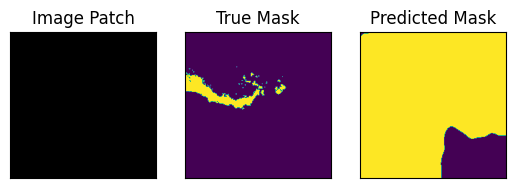

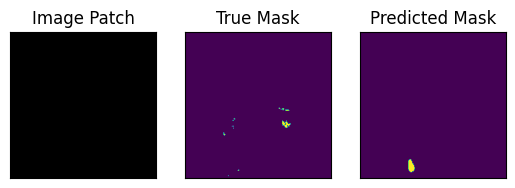

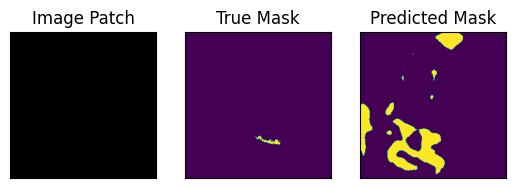

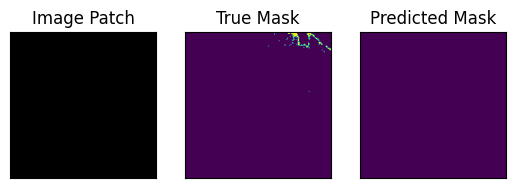

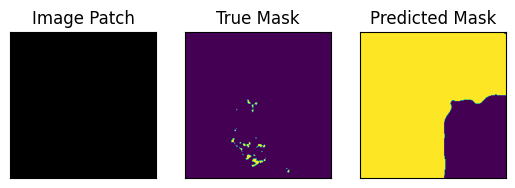

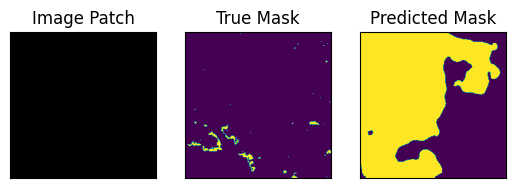

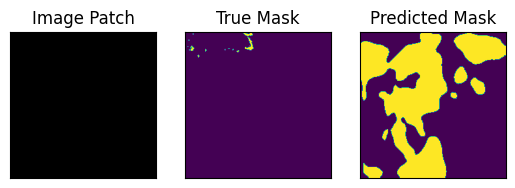

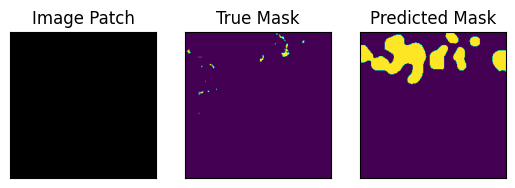

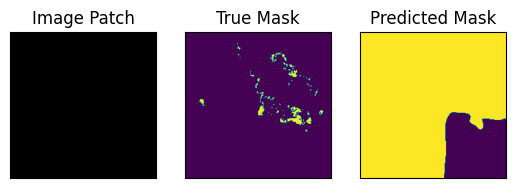

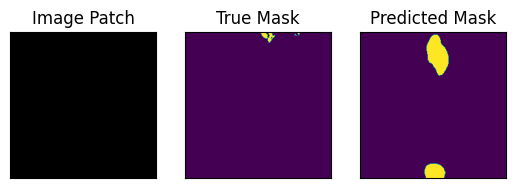

In [ ]:
preds = tuned_model.predict(x_test)

from sklearn import metrics


accuracy = metrics.accuracy_score(np.rint(preds.reshape(-1)), y_test.reshape(-1))
precision = metrics.precision_score(np.rint(preds.reshape(-1)), y_test.reshape(-1))
recall = metrics.recall_score(np.rint(preds.reshape(-1)), y_test.reshape(-1))
IoU = metrics.jaccard_score(np.rint(preds.reshape(-1)), y_test.reshape(-1))

print("Accuracy ", accuracy)
print("Precison ", precision)
print("Recall ", recall)
print("IoU", IoU)

for i in range(len(x_test[0:10])):

  true_img = x_test[i]
  mask = y_test[i]
  prediction_image = np.rint(preds[i])

  fig, (ax, m_ax, p_ax) = plt.subplots(ncols = 3)
  ax.imshow(true_img*3.5/255)
  ax.set_title('Image Patch')
  ax.tick_params(axis = 'x' , bottom = False, labelbottom = False)
  ax.tick_params(axis = 'y' , left = False, labelleft = False)


  m_ax.imshow(mask)
  m_ax.set_title('True Mask')
  m_ax.tick_params(axis = 'x' , bottom = False, labelbottom = False)
  m_ax.tick_params(axis = 'y' , left = False, labelleft = False)

  p_ax.imshow(prediction_image)
  p_ax.set_title('Predicted Mask')
  p_ax.tick_params(axis = 'x' , bottom = False, labelbottom = False)
  p_ax.tick_params(axis = 'y' , left = False, labelleft = False)

TRANSFER LEARNING FINE TUNING
---

In [ ]:
from bayes_opt import BayesianOptimization

# Import the required loss functions

# Define the objective function
def objective(learning_rate, dropout_rate):
    # Build the model with the current hyperparameters
    tf.keras.backend.clear_session()

    model = DeeplabV3Plus(224, 1, dropout_rate=dropout_rate, weights = 'imagenet', frozen_base = True)   

    datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True)

    model.compile(optimizer=keras.optimizers.Adam(learning_rate = learning_rate), loss=dice_loss,
                  metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

    history = model.fit(datagen.flow(x_train, y_train, batch_size=16),
                        validation_data=(x_val, y_val), epochs=100, verbose=0)

    p = history.history['val_precision'][-1]
    r = history.history['val_recall'][-1]
    error_stopper = 0.0000000001

    f1 = 2*(p*r)/(p+r + error_stopper)

    # Return the validation accuracy as the objective value to maximize
    return f1

# Define the parameter space
pbounds = {'learning_rate': (1e-5, 1e-2),
           'dropout_rate': (0, 0.5)
           }

# Create the optimizer
optimizer = BayesianOptimization(f=objective, pbounds=pbounds)

# Perform the optimization
optimizer.maximize(init_points=5, n_iter=10)

# Get the best set of hyperparameters
best_params = optimizer.max['params']
print(best_params)


# best_learning_rate = best_params['learning_rate']
# best_dropout_rate = best_params['dropout_rate']
# best_loss_function = best_params['loss_function']

|   iter    |  target   | dropou... | learni... |
-------------------------------------------------
| 1         | 0.0       | 0.4492    | 0.00716   |
| 2         | 0.0       | 0.4566    | 0.007921  |
| 3         | 0.0       | 0.1706    | 0.005883  |
| 4         | 0.0       | 0.2688    | 0.007366  |
| 5         | 0.0       | 0.2303    | 0.003786  |
| 6         | 0.0       | 0.000162  | 0.002197  |
| 7         | 0.0       | 6.744e-05 | 0.005768  |
| 8         | 0.0       | 0.5       | 0.007514  |
| 9         | 0.0       | 8.604e-05 | 0.002226  |
| 10        | 0.0       | 0.5       | 0.009979  |
| 11        | 0.0       | 1.58e-05  | 0.001085  |
| 12        | 0.0       | 0.5       | 0.003859  |
| 13        | 0.0       | 2.447e-05 | 0.001628  |
| 14        | 0.0       | 0.4999    | 0.001142  |
| 15        | 0.0       | 4.456e-06 | 0.005239  |
{'dropout_rate': 0.4492388802645591, 'learning_rate': 0.007160199246062161}


In [ ]:
tf.keras.backend.clear_session()

datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True)
tuned_model = DeeplabV3Plus(224, 1, dropout_rate=0.13857637974829567, weights = 'imagenet', frozen_base = True)   
tuned_model.compile( optimizer =keras.optimizers.Adam(0.009279677186633268)
              ,loss= dice_loss
              ,metrics=[ 'accuracy' , tf.keras.metrics.Recall() , tf.keras.metrics.Precision()]
              )

tuned_history = tuned_model.fit(datagen.flow(x_train, y_train, batch_size=16),
                      validation_data=(x_val, y_val), epochs=500)

tuned_model.save("resnetDLV3_TL_tuned_500e_bs16.h5")

np.save('history_resnetDLV3_TL_tuned_500e_bs16.npy',tuned_history.history)

94765736/94765736 [==============================] - 6s 0us/step
Epoch 1/500
22/22 [==============================] - 9s 226ms/step - loss: 0.9796 - accuracy: 0.5646 - recall: 0.4155 - precision: 0.0101 - val_loss: 0.9791 - val_accuracy: 0.1113 - val_recall: 0.8959 - val_precision: 0.0106
Epoch 2/500
22/22 [==============================] - 4s 174ms/step - loss: 0.9792 - accuracy: 0.5915 - recall: 0.4247 - precision: 0.0110 - val_loss: 0.9793 - val_accuracy: 0.8822 - val_recall: 0.0969 - val_precision: 0.0094
Epoch 3/500
22/22 [==============================] - 4s 174ms/step - loss: 0.9786 - accuracy: 0.4316 - recall: 0.6689 - precision: 0.0123 - val_loss: 0.9792 - val_accuracy: 0.9788 - val_recall: 0.0087 - val_precision: 0.0086
Epoch 4/500
22/22 [==============================] - 4s 175ms/step - loss: 0.9778 - accuracy: 0.6143 - recall: 0.5807 - precision: 0.0158 - val_loss: 0.9792 - val_accuracy: 0.9878 - val_recall: 0.0014 - val_precision: 0.0093
Epoch 5/500
22/22 [================

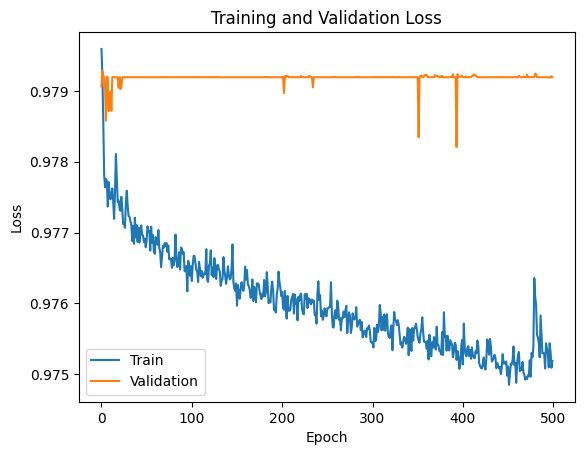

In [ ]:
## Assess at which point the model becomes overfit 

resDL_TL_hist = np.load("history_resnetDLV3_TL_tuned_500e_bs16.npy", allow_pickle = True).item()

plt.plot(resDL_TL_hist['loss'], label='Train')
plt.plot(resDL_TL_hist['val_loss'], label='Validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

We notice no improvement from training with a frozen base or any specific learning and dropout rates. We copy the dropout rate from the model without any loaded weights and set a low learning rate and train to find an overfitting point.

In [ ]:
tf.keras.backend.clear_session()

datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True)
tuned_model = DeeplabV3Plus(224, 1, dropout_rate=0.13857637974829567, weights = 'imagenet', frozen_base = True)   
tuned_model.compile( optimizer =keras.optimizers.Adam(0.00001)
              ,loss= dice_loss
              ,metrics=[ 'accuracy' , tf.keras.metrics.Recall() , tf.keras.metrics.Precision()]
              )

tuned_history = tuned_model.fit(datagen.flow(x_train, y_train, batch_size=16),
                      validation_data=(x_val, y_val), epochs=100)


Epoch 1/100
22/22 [==============================] - 6s 117ms/step - loss: 0.9794 - accuracy: 0.3487 - recall: 0.6387 - precision: 0.0103 - val_loss: 0.9792 - val_accuracy: 0.0981 - val_recall: 0.8890 - val_precision: 0.0104
Epoch 2/100
22/22 [==============================] - 2s 70ms/step - loss: 0.9793 - accuracy: 0.2819 - recall: 0.7424 - precision: 0.0108 - val_loss: 0.9791 - val_accuracy: 0.4265 - val_recall: 0.5569 - val_precision: 0.0103
Epoch 3/100
22/22 [==============================] - 2s 77ms/step - loss: 0.9792 - accuracy: 0.2568 - recall: 0.7924 - precision: 0.0111 - val_loss: 0.9791 - val_accuracy: 0.5030 - val_recall: 0.4975 - val_precision: 0.0107
Epoch 4/100
22/22 [==============================] - 2s 69ms/step - loss: 0.9792 - accuracy: 0.2633 - recall: 0.7901 - precision: 0.0112 - val_loss: 0.9791 - val_accuracy: 0.5160 - val_recall: 0.4843 - val_precision: 0.0107
Epoch 5/100
22/22 [==============================] - 1s 63ms/step - loss: 0.9791 - accuracy: 0.2809 - r

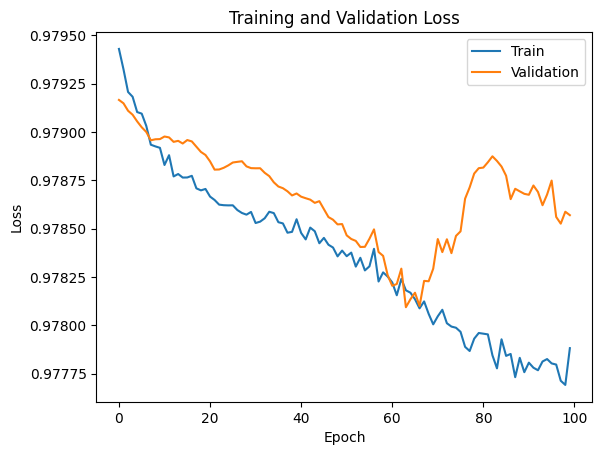

In [ ]:
plt.plot(tuned_history.history['loss'], label='Train')
plt.plot(tuned_history.history['val_loss'], label='Validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

We notice 60 epochs as a over fitting point.

In [ ]:
tf.keras.backend.clear_session()

datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True)
tuned_model = DeeplabV3Plus(224, 1, dropout_rate=0.13857637974829567, weights = 'imagenet', frozen_base = True)   
tuned_model.compile( optimizer =keras.optimizers.Adam(0.00001)
              ,loss= dice_loss
              ,metrics=[ 'accuracy' , tf.keras.metrics.Recall() , tf.keras.metrics.Precision()]
              )

tuned_history = tuned_model.fit(datagen.flow(x_train, y_train, batch_size=16),
                      validation_data=(x_val, y_val), epochs=60)


Epoch 1/60
22/22 [==============================] - 7s 149ms/step - loss: 0.9794 - accuracy: 0.6227 - recall: 0.3832 - precision: 0.0107 - val_loss: 0.9791 - val_accuracy: 0.0855 - val_recall: 0.9313 - val_precision: 0.0107
Epoch 2/60
22/22 [==============================] - 1s 64ms/step - loss: 0.9793 - accuracy: 0.5521 - recall: 0.4954 - precision: 0.0116 - val_loss: 0.9791 - val_accuracy: 0.2766 - val_recall: 0.7601 - val_precision: 0.0111
Epoch 3/60
22/22 [==============================] - 1s 65ms/step - loss: 0.9792 - accuracy: 0.4980 - recall: 0.5659 - precision: 0.0118 - val_loss: 0.9790 - val_accuracy: 0.4945 - val_recall: 0.5613 - val_precision: 0.0118
Epoch 4/60
22/22 [==============================] - 1s 64ms/step - loss: 0.9791 - accuracy: 0.4608 - recall: 0.6170 - precision: 0.0120 - val_loss: 0.9790 - val_accuracy: 0.5665 - val_recall: 0.4918 - val_precision: 0.0121
Epoch 5/60
22/22 [==============================] - 1s 65ms/step - loss: 0.9791 - accuracy: 0.4482 - recall

In [ ]:
## Use this to see where second overfitting point. 

tuned_model.trainable = True 

tuned_model.compile( optimizer =keras.optimizers.Adam(0.00001)
              ,loss= dice_loss
              ,metrics=[ 'accuracy' , tf.keras.metrics.Recall() , tf.keras.metrics.Precision()]
              )

tuned_history2 = tuned_model.fit(datagen.flow(x_train, y_train, batch_size=16),
                      validation_data=(x_val, y_val), epochs=100)


Epoch 1/100
22/22 [==============================] - 9s 158ms/step - loss: 0.9793 - accuracy: 0.5307 - recall_1: 0.5012 - precision_1: 0.0112 - val_loss: 0.9792 - val_accuracy: 0.9894 - val_recall_1: 0.0000e+00 - val_precision_1: 0.0000e+00
Epoch 2/100
22/22 [==============================] - 2s 102ms/step - loss: 0.9787 - accuracy: 0.5499 - recall_1: 0.5449 - precision_1: 0.0127 - val_loss: 0.9792 - val_accuracy: 0.9894 - val_recall_1: 0.0000e+00 - val_precision_1: 0.0000e+00
Epoch 3/100
22/22 [==============================] - 2s 102ms/step - loss: 0.9780 - accuracy: 0.5609 - recall_1: 0.6461 - precision_1: 0.0154 - val_loss: 0.9792 - val_accuracy: 0.9894 - val_recall_1: 0.0000e+00 - val_precision_1: 0.0000e+00
Epoch 4/100
22/22 [==============================] - 2s 106ms/step - loss: 0.9780 - accuracy: 0.5687 - recall_1: 0.6337 - precision_1: 0.0153 - val_loss: 0.9792 - val_accuracy: 0.9894 - val_recall_1: 0.0000e+00 - val_precision_1: 0.0000e+00
Epoch 5/100
22/22 [=================

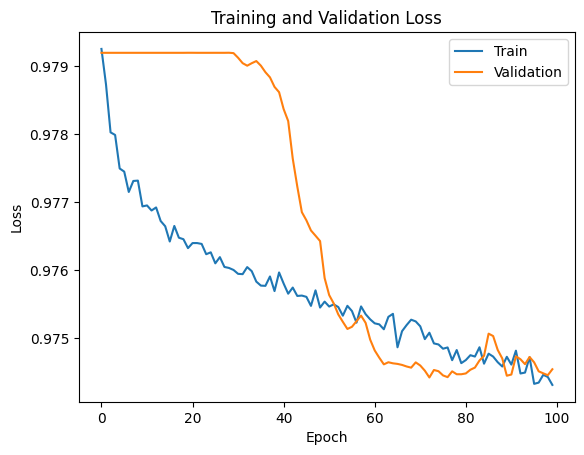

In [ ]:
plt.plot(tuned_history2.history['loss'], label='Train')
plt.plot(tuned_history2.history['val_loss'], label='Validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

We see 60 epochs followed by 50 epochs in fine tuning is good.

In [ ]:
tf.keras.backend.clear_session()

datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True)
tuned_model = DeeplabV3Plus(224, 1, dropout_rate=0.13857637974829567, weights = 'imagenet', frozen_base = True)   
tuned_model.compile( optimizer =keras.optimizers.Adam(0.00001)
              ,loss= dice_loss
              ,metrics=[ 'accuracy' , tf.keras.metrics.Recall() , tf.keras.metrics.Precision()]
              )

tuned_model.fit(datagen.flow(final_x_train, final_y_train, batch_size=16), epochs=60)

tuned_model.trainable = True

tuned_model.compile( optimizer =keras.optimizers.Adam(0.00001)
              ,loss= dice_loss
              ,metrics=[ 'accuracy' , tf.keras.metrics.Recall() , tf.keras.metrics.Precision()]
              )


tuned_history = tuned_model.fit(datagen.flow(final_x_train, final_y_train, batch_size=16), epochs=50)


94765736/94765736 [==============================] - 5s 0us/step
Epoch 1/60
28/28 [==============================] - 21s 193ms/step - loss: 0.9792 - accuracy: 0.3414 - recall: 0.6926 - precision: 0.0110
Epoch 2/60
28/28 [==============================] - 5s 161ms/step - loss: 0.9790 - accuracy: 0.3720 - recall: 0.7196 - precision: 0.0120
Epoch 3/60
28/28 [==============================] - 5s 164ms/step - loss: 0.9788 - accuracy: 0.4097 - recall: 0.7302 - precision: 0.0129
Epoch 4/60
28/28 [==============================] - 5s 170ms/step - loss: 0.9785 - accuracy: 0.4404 - recall: 0.7448 - precision: 0.0139
Epoch 5/60
28/28 [==============================] - 5s 165ms/step - loss: 0.9786 - accuracy: 0.4633 - recall: 0.6866 - precision: 0.0134
Epoch 6/60
28/28 [==============================] - 5s 164ms/step - loss: 0.9785 - accuracy: 0.4759 - recall: 0.7004 - precision: 0.0140
Epoch 7/60
28/28 [==============================] - 5s 162ms/step - loss: 0.9783 - accuracy: 0.4877 - recall: 0.

2/2 [==============================] - 2s 972ms/step


Accuracy  0.844090800382653
Precison  0.7328231575445018
Recall  0.04379369738604815
IoU 0.04310545178770198


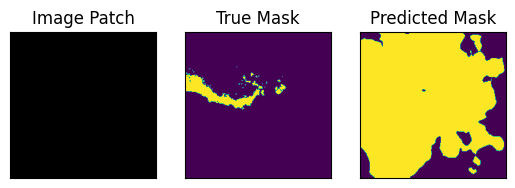

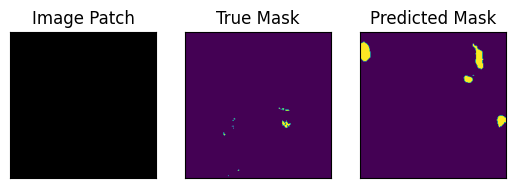

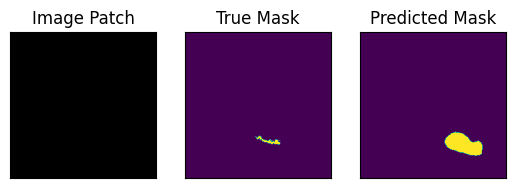

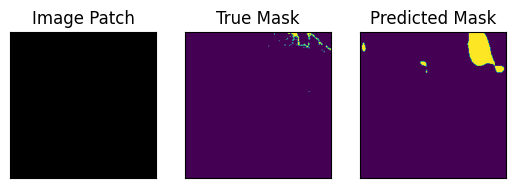

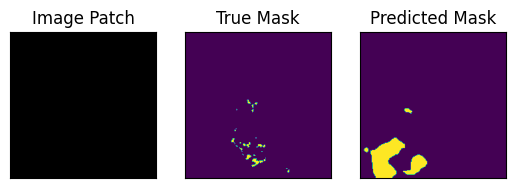

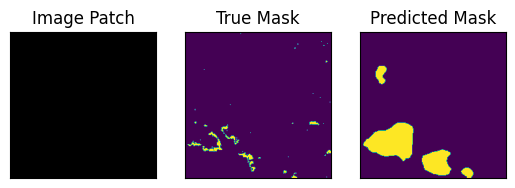

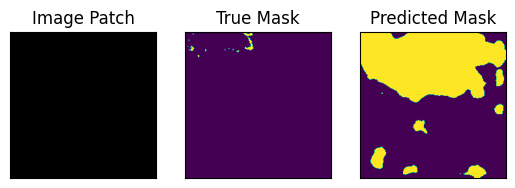

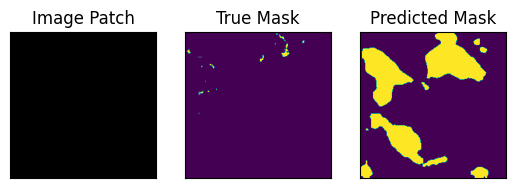

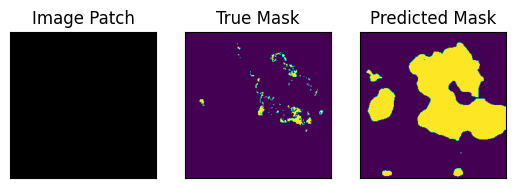

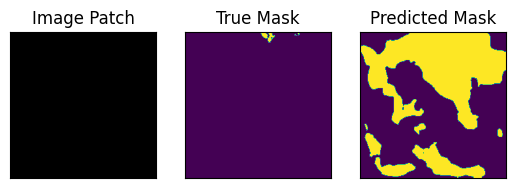

In [ ]:
preds = tuned_model.predict(x_test)

from sklearn import metrics


accuracy = metrics.accuracy_score(np.rint(preds.reshape(-1)), y_test.reshape(-1))
precision = metrics.precision_score(np.rint(preds.reshape(-1)), y_test.reshape(-1))
recall = metrics.recall_score(np.rint(preds.reshape(-1)), y_test.reshape(-1))
IoU = metrics.jaccard_score(np.rint(preds.reshape(-1)), y_test.reshape(-1))

print("Accuracy ", accuracy)
print("Precison ", precision)
print("Recall ", recall)
print("IoU", IoU)

for i in range(len(x_test[0:10])):

  true_img = x_test[i]
  mask = y_test[i]
  prediction_image = np.rint(preds[i])

  fig, (ax, m_ax, p_ax) = plt.subplots(ncols = 3)
  ax.imshow(true_img*3.5/255)
  ax.set_title('Image Patch')
  ax.tick_params(axis = 'x' , bottom = False, labelbottom = False)
  ax.tick_params(axis = 'y' , left = False, labelleft = False)


  m_ax.imshow(mask)
  m_ax.set_title('True Mask')
  m_ax.tick_params(axis = 'x' , bottom = False, labelbottom = False)
  m_ax.tick_params(axis = 'y' , left = False, labelleft = False)

  p_ax.imshow(prediction_image)
  p_ax.set_title('Predicted Mask')
  p_ax.tick_params(axis = 'x' , bottom = False, labelbottom = False)
  p_ax.tick_params(axis = 'y' , left = False, labelleft = False)

UNET
---
---

Adapted and modified from https://github.com/nikhilroxtomar/Semantic-Segmentation-Architecture

In [ ]:
from keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input, Cropping2D
from keras.models import Model
from keras.applications import ResNet50


def conv_block(input, num_filters, dropout_rate = 0):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = layers.Dropout(dropout_rate)(x)

    return x

def decoder_block(input, skip_features, num_filters, dropout_rate = 0):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters, dropout_rate = dropout_rate)
    return x

def build_resnet50_unet(input_shape, weights = None, dropout_rate = 0, frozen_base = False):
    """ Input """
    inputs = Input(input_shape)

    """ Pre-trained Xception Model """
    resnet50 = ResNet50(include_top=False, weights = weights, input_tensor=inputs)

    if frozen_base:
      resnet50.trainable = False

    
    s1 = resnet50.get_layer("input_1").output           ## (512 x 512)
    s2 = resnet50.get_layer("conv1_relu").output        ## (256 x 256)
    s3 = resnet50.get_layer("conv2_block3_out").output  ## (128 x 128)
    s4 = resnet50.get_layer("conv3_block4_out").output  ## (64 x 64)

    """ Bridge """
    b1 = resnet50.get_layer("conv4_block6_out").output  ## (32 x 32)

    """ Decoder """
    d1 = decoder_block(b1, s4, 512, dropout_rate = dropout_rate)                      
    d2 = decoder_block(d1, s3, 256, dropout_rate = dropout_rate)                      
    d3 = decoder_block(d2, s2, 128, dropout_rate = dropout_rate)                      
    d4 = decoder_block(d3, s1, 64, dropout_rate = dropout_rate)                  

    """ Output """
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="Resnet50_U-Net")
    return model

NO PRE LOADED WEIGHTS
---

In [ ]:
from bayes_opt import BayesianOptimization

# Import the required loss functions

# Define the objective function
def objective(learning_rate, dropout_rate):
    # Build the model with the current hyperparameters
    tf.keras.backend.clear_session()

    model = build_resnet50_unet((224,224,3), dropout_rate = dropout_rate)


    datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True)

    model.compile(optimizer=keras.optimizers.Adam(learning_rate = learning_rate), loss=dice_loss,
                  metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

    history = model.fit(datagen.flow(x_train, y_train, batch_size=16),
                        validation_data=(x_val, y_val), epochs=100, verbose=0)

    p = history.history['val_precision'][-1]
    r = history.history['val_recall'][-1]

    f1 = 2*(p*r)/(p+r)

    # Return the validation accuracy as the objective value to maximize
    return f1

# Define the parameter space
pbounds = {'learning_rate': (1e-5, 1e-2),
           'dropout_rate': (0, 0.5)
           }

# Create the optimizer
optimizer = BayesianOptimization(f=objective, pbounds=pbounds)

# Perform the optimization
optimizer.maximize(init_points=5, n_iter=10)

# Get the best set of hyperparameters
best_params = optimizer.max['params']
print(best_params)


# best_learning_rate = best_params['learning_rate']
# best_dropout_rate = best_params['dropout_rate']
# best_loss_function = best_params['loss_function']

|   iter    |  target   | dropou... | learni... |
-------------------------------------------------
| 1         | 0.0214    | 0.05512   | 0.008358  |
| 2         | 0.05569   | 0.2948    | 0.007032  |
| 3         | 0.1246    | 0.02764   | 0.006991  |
| 4         | 0.04264   | 0.1069    | 0.008886  |
| 5         | 0.03139   | 0.284     | 0.002783  |
| 6         | 0.1331    | 0.09018   | 0.005656  |
| 7         | 0.03682   | 0.1864    | 0.006541  |
| 8         | 0.06211   | 0.2603    | 0.006599  |
| 9         | 0.02113   | 0.09003   | 0.005752  |
| 10        | 0.1002    | 0.2676    | 0.007833  |
| 11        | 0.03391   | 0.3489    | 0.006419  |
| 12        | 0.02997   | 0.4023    | 0.002719  |
| 13        | 0.1204    | 0.2674    | 0.007931  |
| 14        | 0.0536    | 0.02769   | 0.006984  |
| 15        | 0.06617   | 0.2674    | 0.008032  |
{'dropout_rate': 0.09018216761892017, 'learning_rate': 0.005656254275372404}


In [ ]:
tf.keras.backend.clear_session()

datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True)
tuned_model = build_resnet50_unet((224,224,3), dropout_rate = 0.09018216761892017)
tuned_model.compile( optimizer =keras.optimizers.Adam(0.005656254275372404)
              ,loss= dice_loss
              ,metrics=[ 'accuracy' , tf.keras.metrics.Recall() , tf.keras.metrics.Precision()]
              )

tuned_history = tuned_model.fit(datagen.flow(x_train, y_train, batch_size=16),
                      validation_data=(x_val, y_val), epochs=500)

tuned_model.save("resnetUNET_NW_tuned_500e_bs16.h5")

np.save('history_resnetUNET_NW_tuned_500e_bs16.npy',tuned_history.history)

Epoch 1/500
22/22 [==============================] - 45s 1s/step - loss: 0.9795 - accuracy: 0.7241 - recall: 0.2462 - precision: 0.0096 - val_loss: 0.9790 - val_accuracy: 0.0106 - val_recall: 1.0000 - val_precision: 0.0106
Epoch 2/500
22/22 [==============================] - 14s 654ms/step - loss: 0.9792 - accuracy: 0.5520 - recall: 0.4713 - precision: 0.0111 - val_loss: 0.9790 - val_accuracy: 0.0106 - val_recall: 1.0000 - val_precision: 0.0106
Epoch 3/500
22/22 [==============================] - 14s 654ms/step - loss: 0.9789 - accuracy: 0.5445 - recall: 0.5262 - precision: 0.0121 - val_loss: 0.9792 - val_accuracy: 0.9894 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 4/500
22/22 [==============================] - 14s 654ms/step - loss: 0.9788 - accuracy: 0.4887 - recall: 0.5831 - precision: 0.0119 - val_loss: 0.9793 - val_accuracy: 0.9346 - val_recall: 0.0441 - val_precision: 0.0084
Epoch 5/500
22/22 [==============================] - 14s 654ms/step - loss: 0.9792 - accura

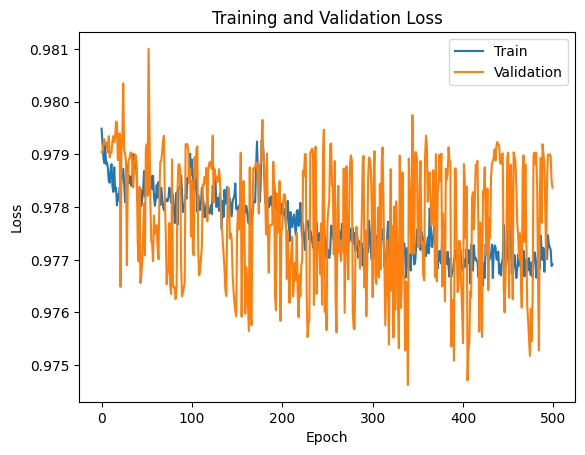

In [ ]:
## Assess at which point the model becomes overfit 

resUNET_NW_hist = np.load("history_resnetUNET_NW_tuned_500e_bs16.npy", allow_pickle = True).item()

plt.plot(resUNET_NW_hist['loss'], label='Train')
plt.plot(resUNET_NW_hist['val_loss'], label='Validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
!pip install keras-flops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


FLOPS: 7.78e+02 G


In [ ]:
tf.keras.backend.clear_session()

datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True)
tuned_model = build_resnet50_unet((224,224,3), dropout_rate = 0.09018216761892017)
tuned_model.compile( optimizer =keras.optimizers.Adam(0.005656254275372404)
              ,loss= dice_loss
              ,metrics=[ 'accuracy' , tf.keras.metrics.Recall() , tf.keras.metrics.Precision()]
              )

tuned_history = tuned_model.fit(datagen.flow(final_x_train, final_y_train, batch_size=16), epochs=100)


Epoch 1/100


KeyboardInterrupt: ignored

2/2 [==============================] - 1s 91ms/step


Accuracy  0.2934111926020408
Precison  0.9872733322242555
Recall  0.013216251457306353
IoU 0.013214000227117368


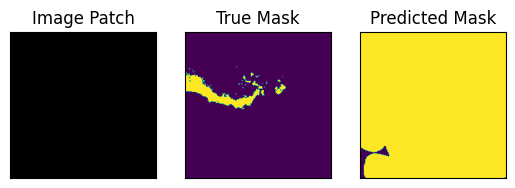

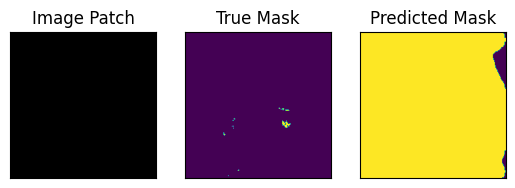

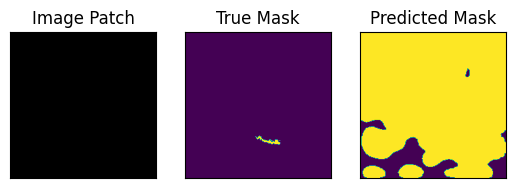

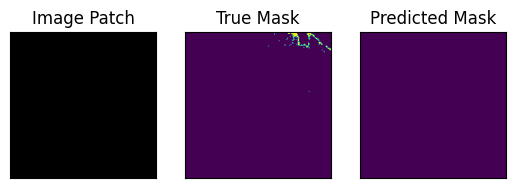

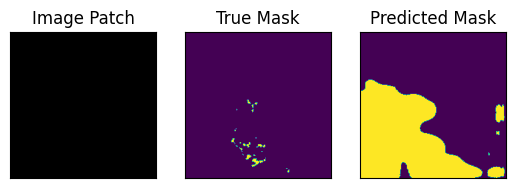

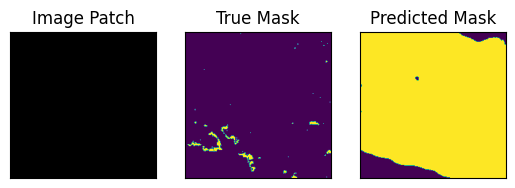

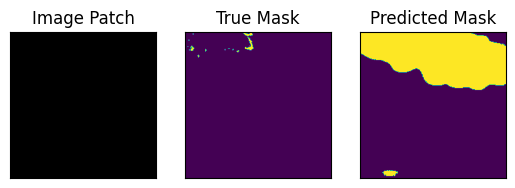

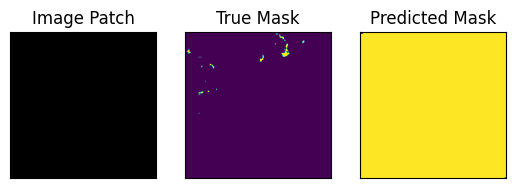

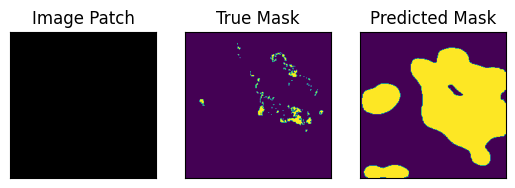

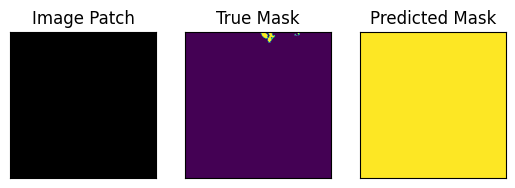

In [ ]:
preds = tuned_model.predict(x_test)

from sklearn import metrics


accuracy = metrics.accuracy_score(np.rint(preds.reshape(-1)), y_test.reshape(-1))
precision = metrics.precision_score(np.rint(preds.reshape(-1)), y_test.reshape(-1))
recall = metrics.recall_score(np.rint(preds.reshape(-1)), y_test.reshape(-1))
IoU = metrics.jaccard_score(np.rint(preds.reshape(-1)), y_test.reshape(-1))

print("Accuracy ", accuracy)
print("Precison ", precision)
print("Recall ", recall)
print("IoU", IoU)

for i in range(len(x_test[0:10])):

  true_img = x_test[i]
  mask = y_test[i]
  prediction_image = np.rint(preds[i])

  fig, (ax, m_ax, p_ax) = plt.subplots(ncols = 3)
  ax.imshow(true_img*3.5/255)
  ax.set_title('Image Patch')
  ax.tick_params(axis = 'x' , bottom = False, labelbottom = False)
  ax.tick_params(axis = 'y' , left = False, labelleft = False)


  m_ax.imshow(mask)
  m_ax.set_title('True Mask')
  m_ax.tick_params(axis = 'x' , bottom = False, labelbottom = False)
  m_ax.tick_params(axis = 'y' , left = False, labelleft = False)

  p_ax.imshow(prediction_image)
  p_ax.set_title('Predicted Mask')
  p_ax.tick_params(axis = 'x' , bottom = False, labelbottom = False)
  p_ax.tick_params(axis = 'y' , left = False, labelleft = False)

TRANSFER LEARNING
---

In [ ]:
from bayes_opt import BayesianOptimization

# Import the required loss functions

# Define the objective function
def objective(learning_rate, dropout_rate):
    # Build the model with the current hyperparameters
    tf.keras.backend.clear_session()

    model = build_resnet50_unet((224,224,3), dropout_rate = dropout_rate, weights = 'imagenet', frozen_base = True)


    datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True)

    model.compile(optimizer=keras.optimizers.Adam(learning_rate = learning_rate), loss=dice_loss,
                  metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

    history = model.fit(datagen.flow(x_train, y_train, batch_size=16),
                        validation_data=(x_val, y_val), epochs=100, verbose=0)

    p = history.history['val_precision'][-1]
    r = history.history['val_recall'][-1]

    f1 = 2*(p*r)/(p+r)

    # Return the validation accuracy as the objective value to maximize
    return f1

# Define the parameter space
pbounds = {'learning_rate': (1e-5, 1e-2),
           'dropout_rate': (0, 0.5)
           }

# Create the optimizer
optimizer = BayesianOptimization(f=objective, pbounds=pbounds)

# Perform the optimization
optimizer.maximize(init_points=5, n_iter=10)

# Get the best set of hyperparameters
best_params = optimizer.max['params']
print(best_params)



|   iter    |  target   | dropou... | learni... |
-------------------------------------------------
94765736/94765736 [==============================] - 4s 0us/step
| 1         | 0.05589   | 0.2618    | 0.001231  |
| 2         | 0.02327   | 0.09905   | 0.009066  |
| 3         | 0.00142   | 0.3863    | 0.002941  |
| 4         | 0.02198   | 0.3243    | 0.006207  |
| 5         | 0.02244   | 0.3881    | 0.00715   |
| 6         | 0.003675  | 0.2629    | 0.003536  |
| 7         | 0.03878   | 0.3959    | 0.001206  |
| 8         | 0.0002706 | 0.4839    | 0.008656  |
| 9         | 0.02382   | 0.3244    | 0.006134  |
| 10        | 0.05856   | 0.2614    | 0.0004567 |
| 11        | 0.02304   | 0.1908    | 0.004669  |
| 12        | 0.05268   | 0.2603    | 0.001185  |
| 13        | 0.03      | 0.2632    | 0.0004599 |
| 14        | 0.0471    | 0.2589    | 2.811e-05 |
| 15        | 0.05103   | 0.2575    | 0.002069  |
{'dropout_rate': 0.26142416534662677, 'learning_rate': 0.00045667759520248474}


In [ ]:
tf.keras.backend.clear_session()

datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True)
tuned_model = build_resnet50_unet((224,224,3), dropout_rate = 0.26142416534662677, weights = 'imagenet', frozen_base = True)
tuned_model.compile( optimizer =keras.optimizers.Adam(0.00045667759520248474)
              ,loss= dice_loss
              ,metrics=[ 'accuracy' , tf.keras.metrics.Recall() , tf.keras.metrics.Precision()]
              )

tuned_history = tuned_model.fit(datagen.flow(x_train, y_train, batch_size=16),
                      validation_data=(x_val, y_val), epochs=500)



94765736/94765736 [==============================] - 0s 0us/step
Epoch 1/500
22/22 [==============================] - 25s 421ms/step - loss: 0.9795 - accuracy: 0.6296 - recall: 0.3465 - precision: 0.0099 - val_loss: 0.9791 - val_accuracy: 0.2006 - val_recall: 0.8160 - val_precision: 0.0108
Epoch 2/500
22/22 [==============================] - 4s 165ms/step - loss: 0.9793 - accuracy: 0.3651 - recall: 0.6403 - precision: 0.0105 - val_loss: 0.9791 - val_accuracy: 0.3192 - val_recall: 0.6936 - val_precision: 0.0108
Epoch 3/500
22/22 [==============================] - 4s 165ms/step - loss: 0.9792 - accuracy: 0.5760 - recall: 0.4626 - precision: 0.0115 - val_loss: 0.9790 - val_accuracy: 0.1798 - val_recall: 0.8489 - val_precision: 0.0109
Epoch 4/500
22/22 [==============================] - 4s 165ms/step - loss: 0.9790 - accuracy: 0.5204 - recall: 0.5516 - precision: 0.0121 - val_loss: 0.9789 - val_accuracy: 0.5007 - val_recall: 0.5264 - val_precision: 0.0112
Epoch 5/500
22/22 [===============

In [ ]:

tuned_model.save("resnetUNET_TL_tuned_500e_bs16.h5")

np.save('history_resnetUNET_TL_tuned_500e_bs16.npy',tuned_history.history)

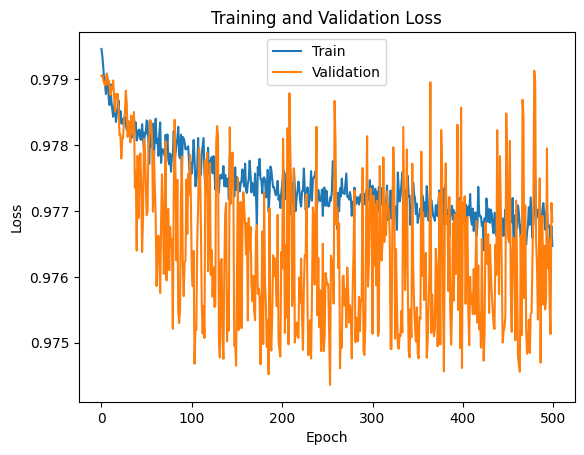

In [ ]:
## Assess at which point the model becomes overfit 

resUNET_TL_hist = np.load("history_resnetUNET_TL_tuned_500e_bs16.npy", allow_pickle = True).item()

plt.plot(resUNET_TL_hist['loss'], label='Train')
plt.plot(resUNET_TL_hist['val_loss'], label='Validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

After 50 epochs we start to observe wild fluctuations uggesting possible overfitting or a validation set that is not representitive of our training set. 

In [ ]:
tf.keras.backend.clear_session()

datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True)
tuned_model = build_resnet50_unet((224,224,3), dropout_rate = 0.26142416534662677, weights = 'imagenet', frozen_base = True)
tuned_model.compile( optimizer =keras.optimizers.Adam(0.00045667759520248474)
              ,loss= dice_loss
              ,metrics=[ 'accuracy' , tf.keras.metrics.Recall() , tf.keras.metrics.Precision()]
              )

tuned_history = tuned_model.fit(datagen.flow(x_train, y_train, batch_size=16),
                      validation_data=(x_val, y_val), epochs=50)

Epoch 1/50
22/22 [==============================] - 26s 427ms/step - loss: 0.9793 - accuracy: 0.2683 - recall: 0.7482 - precision: 0.0107 - val_loss: 0.9791 - val_accuracy: 0.9894 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 2/50
22/22 [==============================] - 4s 165ms/step - loss: 0.9791 - accuracy: 0.2148 - recall: 0.8198 - precision: 0.0109 - val_loss: 0.9789 - val_accuracy: 0.9873 - val_recall: 0.0015 - val_precision: 0.0075
Epoch 3/50
22/22 [==============================] - 4s 167ms/step - loss: 0.9791 - accuracy: 0.2830 - recall: 0.7581 - precision: 0.0110 - val_loss: 0.9788 - val_accuracy: 0.9747 - val_recall: 0.0243 - val_precision: 0.0170
Epoch 4/50
22/22 [==============================] - 4s 164ms/step - loss: 0.9789 - accuracy: 0.4732 - recall: 0.6110 - precision: 0.0121 - val_loss: 0.9792 - val_accuracy: 0.9892 - val_recall: 5.8527e-05 - val_precision: 0.0042
Epoch 5/50
22/22 [==============================] - 4s 168ms/step - loss: 0.9790 - accuracy

In [ ]:
tuned_model.trainable = True


In [ ]:
datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True)
tuned_model.compile( optimizer =keras.optimizers.Adam(0.00001)
              ,loss= dice_loss
              ,metrics=[ 'accuracy' , tf.keras.metrics.Recall() , tf.keras.metrics.Precision()]
              )

tuned_history_UTL_2 = tuned_model.fit(datagen.flow(x_train, y_train, batch_size=16),
                      validation_data=(x_val, y_val), epochs=100)

Epoch 1/100
22/22 [==============================] - 12s 271ms/step - loss: 0.9780 - accuracy: 0.6855 - recall_1: 0.4799 - precision_1: 0.0161 - val_loss: 0.9792 - val_accuracy: 0.9894 - val_recall_1: 4.8773e-04 - val_precision_1: 0.3623
Epoch 2/100
22/22 [==============================] - 4s 203ms/step - loss: 0.9784 - accuracy: 0.6913 - recall_1: 0.4258 - precision_1: 0.0146 - val_loss: 0.9792 - val_accuracy: 0.9894 - val_recall_1: 0.0000e+00 - val_precision_1: 0.0000e+00
Epoch 3/100
22/22 [==============================] - 4s 203ms/step - loss: 0.9777 - accuracy: 0.6998 - recall_1: 0.5023 - precision_1: 0.0176 - val_loss: 0.9792 - val_accuracy: 0.9894 - val_recall_1: 0.0000e+00 - val_precision_1: 0.0000e+00
Epoch 4/100
22/22 [==============================] - 5s 204ms/step - loss: 0.9779 - accuracy: 0.7064 - recall_1: 0.4793 - precision_1: 0.0172 - val_loss: 0.9792 - val_accuracy: 0.9894 - val_recall_1: 0.0000e+00 - val_precision_1: 0.0000e+00
Epoch 5/100
22/22 [====================

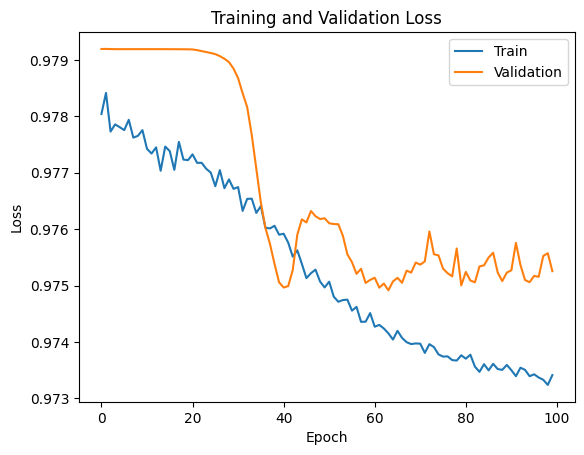

In [ ]:


plt.plot(tuned_history_UTL_2.history['loss'], label='Train')
plt.plot(tuned_history_UTL_2.history['val_loss'], label='Validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

We see it starts to become overfit around epoch 40-45

In [ ]:
tf.keras.backend.clear_session()

datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True)
tuned_model = build_resnet50_unet((224,224,3), dropout_rate = 0.26142416534662677, weights = 'imagenet', frozen_base = True)
tuned_model.compile( optimizer =keras.optimizers.Adam(0.00045667759520248474)
              ,loss= dice_loss
              ,metrics=[ 'accuracy' , tf.keras.metrics.Recall() , tf.keras.metrics.Precision()]
              )

tuned_history = tuned_model.fit(datagen.flow(final_x_train, final_y_train, batch_size=16), epochs=50)

Epoch 1/50
28/28 [==============================] - 9s 152ms/step - loss: 0.9792 - accuracy: 0.2907 - recall: 0.7350 - precision: 0.0108
Epoch 2/50
28/28 [==============================] - 4s 153ms/step - loss: 0.9791 - accuracy: 0.2191 - recall: 0.8188 - precision: 0.0110
Epoch 3/50
28/28 [==============================] - 4s 153ms/step - loss: 0.9790 - accuracy: 0.2320 - recall: 0.8124 - precision: 0.0111
Epoch 4/50
28/28 [==============================] - 4s 152ms/step - loss: 0.9790 - accuracy: 0.3142 - recall: 0.7275 - precision: 0.0111
Epoch 5/50
28/28 [==============================] - 4s 153ms/step - loss: 0.9789 - accuracy: 0.5411 - recall: 0.5229 - precision: 0.0120
Epoch 6/50
28/28 [==============================] - 4s 153ms/step - loss: 0.9788 - accuracy: 0.5489 - recall: 0.5337 - precision: 0.0124
Epoch 7/50
28/28 [==============================] - 4s 152ms/step - loss: 0.9787 - accuracy: 0.5789 - recall: 0.5113 - precision: 0.0128
Epoch 8/50
28/28 [=======================

In [ ]:
tuned_model.trainable = True

In [ ]:
datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True)
tuned_model.compile( optimizer =keras.optimizers.Adam(0.00001)
              ,loss= dice_loss
              ,metrics=[ 'accuracy' , tf.keras.metrics.Recall() , tf.keras.metrics.Precision()]
              )

tuned_history = tuned_model.fit(datagen.flow(final_x_train, final_y_train, batch_size=16), epochs=40)

Epoch 1/40
28/28 [==============================] - 12s 191ms/step - loss: 0.9782 - accuracy: 0.6501 - recall_1: 0.4860 - precision_1: 0.0147
Epoch 2/40
28/28 [==============================] - 5s 190ms/step - loss: 0.9782 - accuracy: 0.6492 - recall_1: 0.4885 - precision_1: 0.0147
Epoch 3/40
28/28 [==============================] - 5s 191ms/step - loss: 0.9779 - accuracy: 0.6594 - recall_1: 0.5244 - precision_1: 0.0162
Epoch 4/40
28/28 [==============================] - 5s 189ms/step - loss: 0.9777 - accuracy: 0.6676 - recall_1: 0.5386 - precision_1: 0.0170
Epoch 5/40
28/28 [==============================] - 5s 189ms/step - loss: 0.9777 - accuracy: 0.6785 - recall_1: 0.5270 - precision_1: 0.0172
Epoch 6/40
28/28 [==============================] - 5s 195ms/step - loss: 0.9779 - accuracy: 0.6852 - recall_1: 0.4977 - precision_1: 0.0167
Epoch 7/40
28/28 [==============================] - 5s 189ms/step - loss: 0.9778 - accuracy: 0.6984 - recall_1: 0.4959 - precision_1: 0.0173
Epoch 8/40
2

2/2 [==============================] - 3s 2s/step


Accuracy  0.6663863201530612
Precison  0.7883879554150723
Recall  0.02227921178884817
IoU 0.022146774370681577


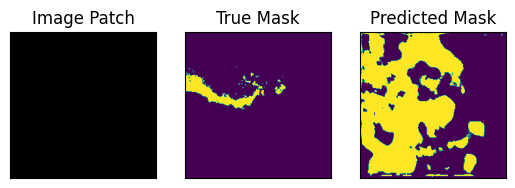

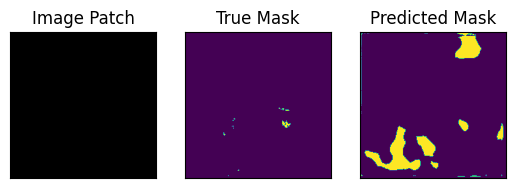

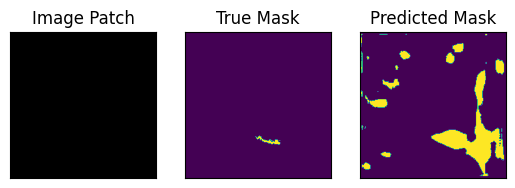

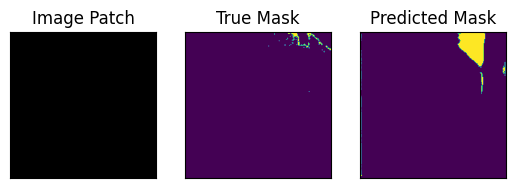

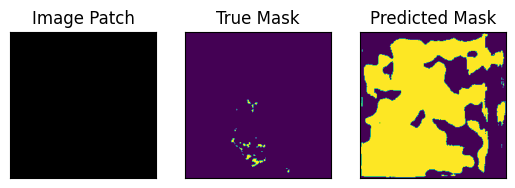

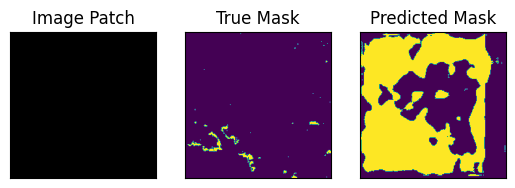

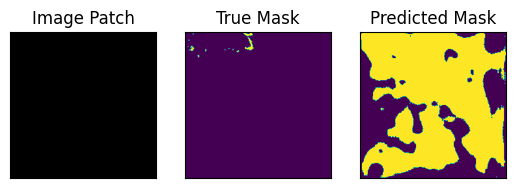

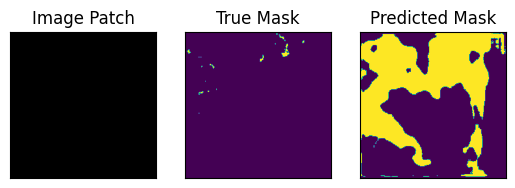

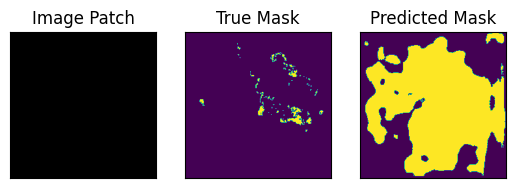

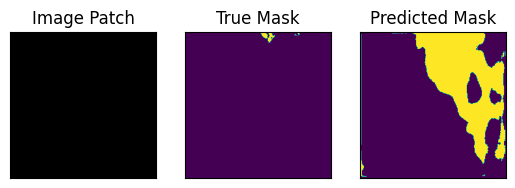

In [ ]:
preds = tuned_model.predict(x_test)

from sklearn import metrics


accuracy = metrics.accuracy_score(np.rint(preds.reshape(-1)), y_test.reshape(-1))
precision = metrics.precision_score(np.rint(preds.reshape(-1)), y_test.reshape(-1))
recall = metrics.recall_score(np.rint(preds.reshape(-1)), y_test.reshape(-1))
IoU = metrics.jaccard_score(np.rint(preds.reshape(-1)), y_test.reshape(-1))

print("Accuracy ", accuracy)
print("Precison ", precision)
print("Recall ", recall)
print("IoU", IoU)

for i in range(len(x_test[0:10])):

  true_img = x_test[i]
  mask = y_test[i]
  prediction_image = np.rint(preds[i])

  fig, (ax, m_ax, p_ax) = plt.subplots(ncols = 3)
  ax.imshow(true_img*3.5/255)
  ax.set_title('Image Patch')
  ax.tick_params(axis = 'x' , bottom = False, labelbottom = False)
  ax.tick_params(axis = 'y' , left = False, labelleft = False)


  m_ax.imshow(mask)
  m_ax.set_title('True Mask')
  m_ax.tick_params(axis = 'x' , bottom = False, labelbottom = False)
  m_ax.tick_params(axis = 'y' , left = False, labelleft = False)

  p_ax.imshow(prediction_image)
  p_ax.set_title('Predicted Mask')
  p_ax.tick_params(axis = 'x' , bottom = False, labelbottom = False)
  p_ax.tick_params(axis = 'y' , left = False, labelleft = False)


Get FLOPS
---


In [ ]:
pip install keras-flops

In [ ]:
from keras_flops import get_flops


In [ ]:
tf.keras.backend.clear_session()


tuned_model = DeeplabV3Plus(224, 1)   


flops = get_flops(tuned_model, batch_size=16)

print(f"FLOPS: {flops / 10 ** 9:.03} G")

FLOPS: 2.51e+02 G


In [ ]:
tf.keras.backend.clear_session()


tuned_model = build_resnet50_unet((224,224,3))


flops = get_flops(tuned_model, batch_size=16)

print(f"FLOPS: {flops / 10 ** 9:.03} G")

FLOPS: 7.78e+02 G


In [ ]:
os.chdir('drive/MyDrive/COMP90055/code/all_data')


In [ ]:
tf.keras.backend.clear_session()

tuned_model = DeeplabV3Plus(229,1)

tf.keras.utils.plot_model (tuned_model, to_file = 'res_DL_PLOT.png', show_shapes = True, show_layer_names = True)

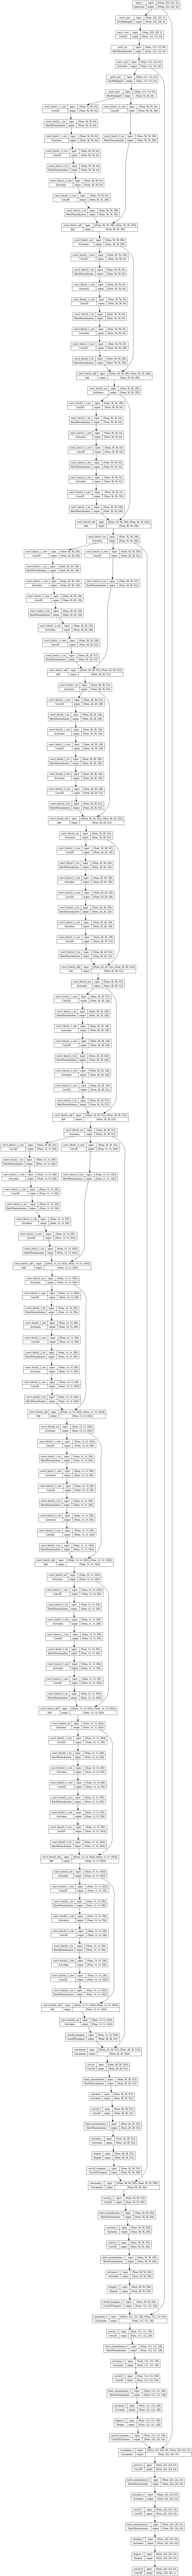

In [ ]:
tf.keras.backend.clear_session()

tuned_model = build_resnet50_unet((224,224,3))

tf.keras.utils.plot_model (tuned_model, to_file = 'res_UNET_PLOT.png', show_shapes = True, show_layer_names = True)